In [ ]:
!pip install transformers
!pip install huggingface_hub
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `magang5` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-crede

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# import data
data = pd.read_csv("/content/balanced-data-for-ft.csv")
data.head()

,text,labels
0,pelayanan bidan dan perawat di ruang bersalin ...,positive
1,Dari masa kanak -kanak hingga keluarga telah b...,positive
2,pelayanannya bagus,positive
3,rumah sakit terbaik,positive
4,pelayanan terhadap pasien bpjs dan non bpjs te...,positive


In [ ]:
label_mapping = {'negative' : 0, 'positive' : 1}
data['labels'] = data['labels'].map(label_mapping)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    720 non-null    object
 1   labels  720 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


In [ ]:
# tokenizer
tokenizer = BertTokenizer.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa")

# model
model = BertForSequenceClassification.from_pretrained("ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa", num_labels = 2, ignore_mismatched_sizes=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'].fillna('').tolist(),
    data['labels'].values,
    test_size = 0.3,
    random_state = 42
)

In [ ]:
# dataset
train_df = pd.DataFrame({'text': train_texts, 'labels': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'labels': val_labels})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
# Add tokenization to the dataset mapping
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/504 [00:00<?, ? examples/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

In [ ]:
# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

In [ ]:
# training args
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [ ]:
# Evaluation metric
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    logits, labels = pred
    preds = torch.argmax(torch.tensor(logits), dim=1).numpy()
    labels = labels.astype(int)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='macro')
    }


In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: willywonka99 (willywonka99-sebelas-maret-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.072400,0.016485,0.990741,0.990661
2,0.000400,0.000220,1.000000,1.000000
3,0.000300,0.000166,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=189, training_loss=0.0816293009569149, metrics={'train_runtime': 208.604, 'train_samples_per_second': 7.248, 'train_steps_per_second': 0.906, 'total_flos': 397823915704320.0, 'train_loss': 0.0816293009569149, 'epoch': 3.0})

In [ ]:
from huggingface_hub import upload_folder

repo_id = "willywonka19/indobert-sentiment-rs-2"
model_dir = "/content/results/checkpoint-63"

upload_folder(
    repo_id=repo_id,
    folder_path=model_dir,
    commit_message="Upload fine-tuned IndoBERT sentiment checkpoint"
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  .../results/checkpoint-63/scheduler.pt: 100%|##########| 1.06kB / 1.06kB            

  ...results/checkpoint-63/rng_state.pth:  78%|#######7  | 11.0kB / 14.2kB            

  .../results/checkpoint-63/optimizer.pt:   0%|          | 28.2kB /  885MB            

  ...lts/checkpoint-63/model.safetensors:   0%|          |  554kB /  442MB            

  ...lts/checkpoint-63/training_args.bin:  10%|9         |   509B / 5.30kB            

CommitInfo(commit_url='https://huggingface.co/willywonka19/indobert-sentiment-rs-2/commit/7678fead93d6555be71087acb8b3571519974be4', commit_message='Upload fine-tuned IndoBERT sentiment checkpoint', commit_description='', oid='7678fead93d6555be71087acb8b3571519974be4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/willywonka19/indobert-sentiment-rs-2', endpoint='https://huggingface.co', repo_type='model', repo_id='willywonka19/indobert-sentiment-rs-2'), pr_revision=None, pr_num=None)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


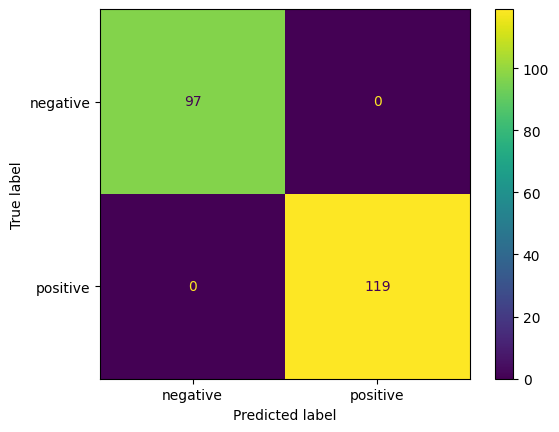

In [ ]:
# confussion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# make prediction on the validation set
predictions = trainer.predict(val_dataset)
pred = np.argmax(predictions.predictions, axis = 1)

# get actual label
actual_label = val_dataset['labels']

# Generate confusion matrix
cm = confusion_matrix(actual_label, pred)

# define class names (matching the labels used in training)
class_names = ['negative', 'positive']

# display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()